In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [44]:
BASE_DIR = 'data_feed/'
# Set the hyperparameters
HIDDEN_SIZE = 32
NUM_EPOCHS = 100
LAG = 10
N_STOCK = 20
BATCH_SIZE = 32

# Data Preprocessing

In [45]:
# check if data_feed directory exist if not 
assert os.path.exists(BASE_DIR)

In [46]:
# list all the files in the data_feed directory
files = os.listdir('data_feed/')

In [47]:
def rename_columns(df: pd.DataFrame, file_name: str) -> None:
    """
    modify columns names (exept date) into the following structure: 
        *column_name*_*stock_name* 
        
    Example: Open_AAPL
    """
    df.rename(columns=dict(zip(df.columns[1:], df.columns[1:] + '_' + file_name[:-4])), inplace=True)

In [48]:
# Read First File into a pandas dataframe
df = pd.read_csv(BASE_DIR+files[0])
rename_columns(df, files[0])

# Merge Everything into a unique DataFrame
for fn in files[1:]:
    df2 = pd.read_csv(BASE_DIR+fn)
    rename_columns(df2, fn)
    result = df.merge(df2, on='Date')
    df = result

df.set_index('Date',inplace=True)
df.index = pd.to_datetime(df.index)

In [49]:
cols = [col for col in df.columns if "Adj Close" in col]
df = df[cols]


# Save all the data onto a file
df.to_csv('AGGREGATED_DATA.csv')

In [50]:
split_date = df.index[0] + pd.offsets.DateOffset(years=8)
train_data = df[df.index <= split_date]
test_data = df[df.index > split_date]
test_data.to_csv('TEST.csv')
train_data.to_csv('TRAIN.csv')

# Data Preparation for the Model

In [51]:
device = torch.device("cpu")
# if torch.cuda.is_available():
#     device = torch.device("cuda")

In [52]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data.values)
scaled_test = scaler.transform(test_data.values)

In [53]:
class TimeSeriesdataset(Dataset):
    def __init__(self, lag: int, data: np.ndarray, device: torch.device):
        self.lag = lag
        self.data = data
        self.device = device

    def __len__(self):
        lenght = len(self.data)
        if lenght % 2 == 0:
            return lenght - 1
        else:
            return lenght

    def __getitem__(self, idx):
        X = self.data[idx:idx+self.lag, :].flatten()
        Y = self.data[idx+self.lag, :]
        return torch.Tensor(X, device=self.device), torch.Tensor(Y, device=self.device)

In [54]:
train_dataset = TimeSeriesdataset(lag=LAG, data=scaled_train, device=device)
test_dataset = TimeSeriesdataset(lag=LAG, data=scaled_test, device=device)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [55]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

In [56]:
# Create the RNN model
model = RNN(input_size=LAG*N_STOCK, hidden_size=HIDDEN_SIZE, output_size=N_STOCK).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [57]:
# Training loop
running_loss = 0.
last_loss = 0.
for epoch in range(NUM_EPOCHS):
    for i, batch in enumerate(train_dataloader):
        X, y = batch
        predict = model(X)
        loss = criterion(predict, y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        last_loss = running_loss/10
        print(f'Epoch: {epoch + 1}/{NUM_EPOCHS}, Loss: {last_loss}')
        running_loss = 0

Epoch: 10/100, Loss: 0.7206300401361659
Epoch: 20/100, Loss: 0.3879242432536557
Epoch: 30/100, Loss: 0.3032997713133227
Epoch: 40/100, Loss: 0.2621433406427968
Epoch: 50/100, Loss: 0.23154315423453226
Epoch: 60/100, Loss: 0.19032636433839797
Epoch: 70/100, Loss: 0.19785408530151471
Epoch: 80/100, Loss: 0.1786757974419743
Epoch: 90/100, Loss: 0.17393868528888562
Epoch: 100/100, Loss: 0.20079022339195945


In [68]:
# Generate predictions
model.eval()
predictions = []
with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
        X, y = batch
        predict = model(X)
        predictions.append(predict.detach().numpy())

# Plots

In [83]:
# join everything into a unique matrix
all_pred = np.zeros(N_STOCK)
for b in predictions:
    for p in b:
        all_pred = np.vstack((all_pred, p))
# Remove zero vector
all_pred = all_pred[1:, :]
all_pred = scaler.inverse_transform(all_pred)

In [89]:
all_real = np.concatenate((scaled_train, scaled_test))
all_real = scaler.inverse_transform(all_real)

In [103]:
all_real.shape[0]

2612

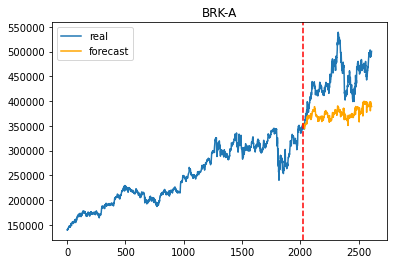

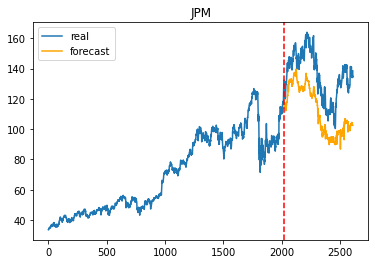

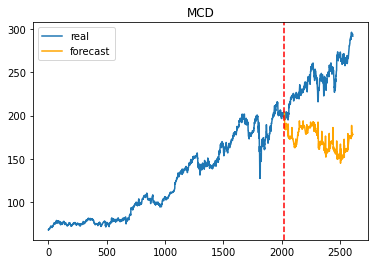

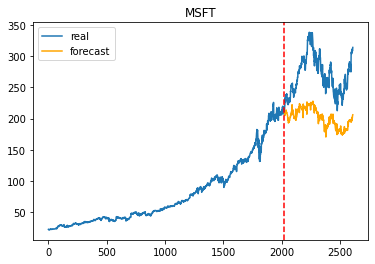

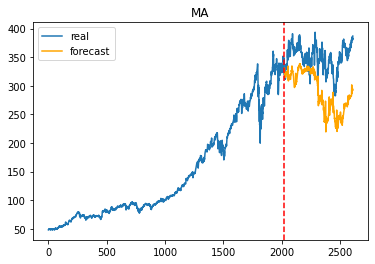

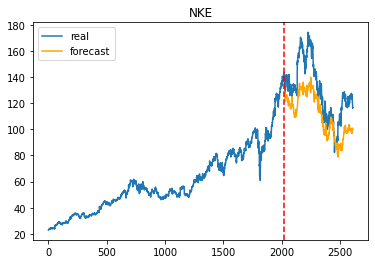

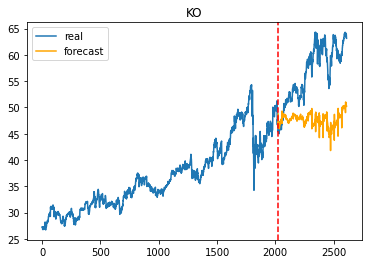

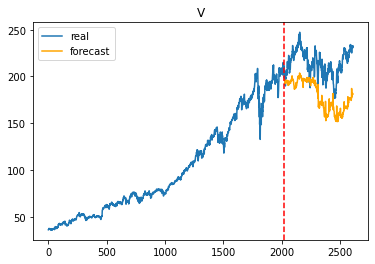

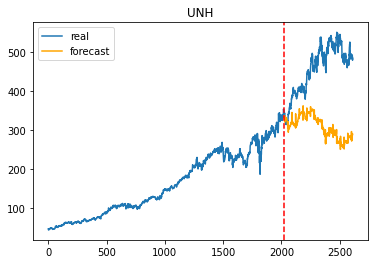

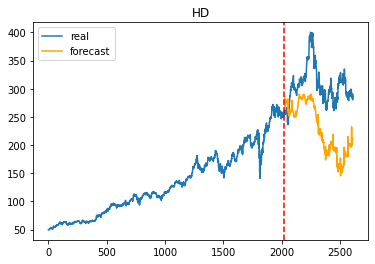

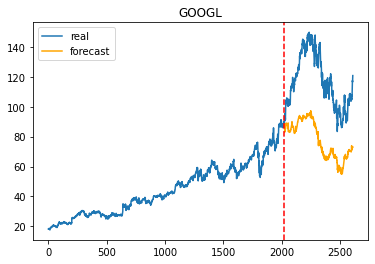

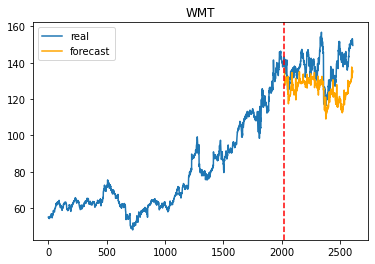

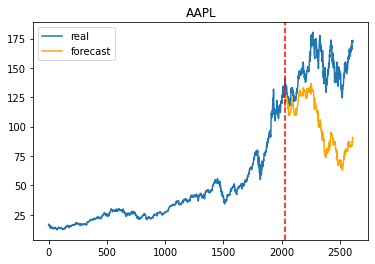

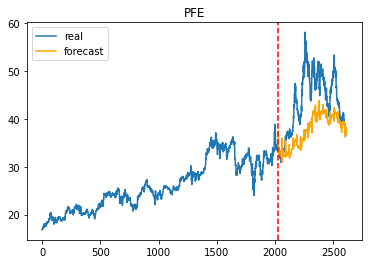

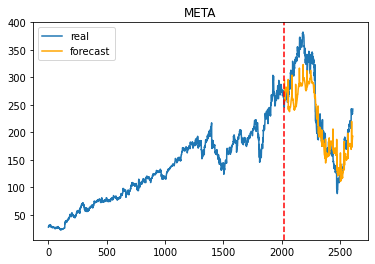

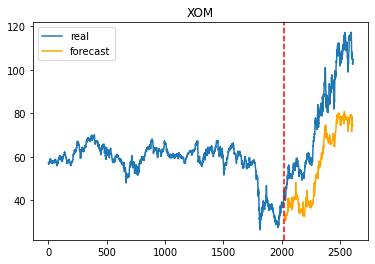

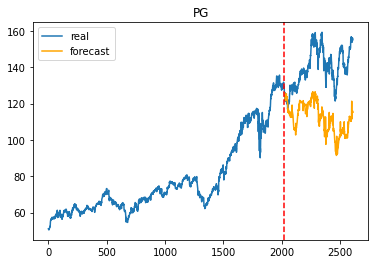

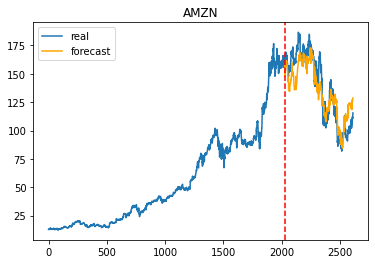

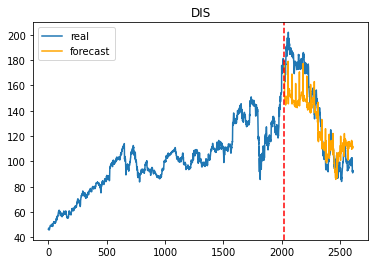

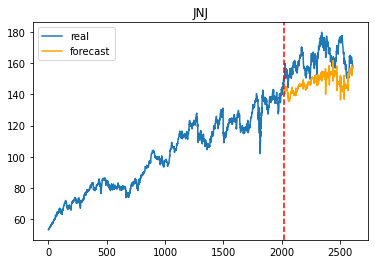

In [109]:
# idx = 0
for idx, file_name in enumerate(files):
    stock = file_name[:-4]
    index_test_start = all_real[:, 0].shape[0] - all_pred.shape[0]
    plt.figure()
    plt.plot( range(all_real.shape[0]) , all_real[:, idx], label='real')
    plt.plot( range(index_test_start,all_real.shape[0]), all_pred[:, idx], color='orange', label='forecast')
    plt.axvline(x=index_test_start, color='red', linestyle='--')
    plt.title(stock)
    plt.legend()
    plt.show()